In [1]:
# LIBRARIES
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [9, 6]
import ot
from ot.datasets import make_1D_gauss as gauss
from scipy.stats import norm
# Particularly important auxiliary function
def find_nearest(array, value, index=False):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx if index else array[idx]

# Kernel Stochastic Gradient Descent w/ Neural Networks Random Features

## Author : Leonardo Martins Bianco

In this code, we implement a projected stochastic gradient descent to determine the coefficients of a random feature expansion of the dual potentials $u$ and $v$, solutions to the regularized optimal transport problem. The code supports entropic regularization and quadratic regularization.
We are interested in ReLU features defined by $\varphi(x) = (\theta z)_{ + }$, where $z := (x, R)$ and our data is uniformly bounded by $R$. However, for experimental purpose our code supports any power of ReLU features. We take a fixed number $m$ of random parameters $\theta_i$ which are uniformly distributed on the sphere of radius $1/R$. Then we can expand $u$ and $v$ on these random features :  
$$
u(x) = \sum_{j=1}^{m} w_{j} \varphi_j(x) = \sum_{j=1}^{m} w_{j} (\theta_j^{ \top } z_{ x })^{ p }_{ + }
$$
(similarly for $v$).
For the details on the theory behind this code, such as error bounds and proof of convergence (and other interesting things), check the final report of my internship (LINK), or the references.

## Setup

### Source and target measures

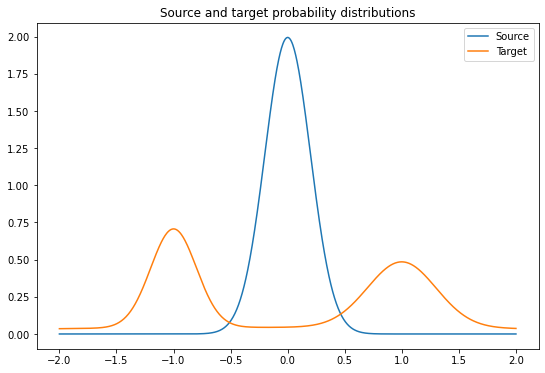

In [2]:
# DOMAIN
dimension = 1
grid_size = 1000
x = np.linspace(-2, 2, grid_size)

# GROUND COST
C = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        C[i, j] = np.square(x[i] - x[j])  

# SOURCE DISTRIBUTION
# Parameters
source_mu = [0]
source_sigma = [0.2]
# Building it
list_source = [norm(loc = source_mu[i], scale = source_sigma[i]) for i in range(len(source_mu))]
source_vect = np.zeros(np.shape(x))
for i in range(len(source_mu)): source_vect += 1./len(source_mu) * list_source[i].pdf(x)
# Support
supp_source = [-2, 2]
index_supp_source = [find_nearest(x, supp_source[i], index=True) for i in range(len(supp_source))]
   
# TARGET DISTRIBUTION
# Parameters
target_mu = [-1, 1, 0] # Gaussian mixture -> [-1, 1, 0]
target_sigma = [0.2, 0.3, 3] # Gaussian mixture -> [0.2, 0.3, 3]
# Building it
list_target = [norm(loc = target_mu[i], scale = target_sigma[i]) for i in range(len(target_mu))]
target_vect = np.zeros(np.shape(x))
for i in range(len(target_mu)): target_vect += 1./len(target_mu) * list_target[i].pdf(x)
# Support
supp_target = [-2, 2]
index_supp_target = [find_nearest(x, supp_target[i], index=True) for i in range(len(supp_target))]

# PLOT SOURCE AND TARGET DISTRIBUTIONS
plt.plot(x,source_vect)
plt.plot(x,target_vect)
plt.legend(['Source', 'Target'])
plt.title('Source and target probability distributions')
plt.show()

### Auxiliary functions

In [323]:
# SAMPLING DISTRIBUTIONS
def sample_dist(list_dist, num_samples):
    sample = np.zeros([dimension, num_samples])
    num_dist = len(list_dist)
    # Sampling from a mixture equals sampling from each of its parts randomly
    for i in range(num_samples):
        random_index = int(np.floor(num_dist * np.random.rand(1)))
        sample[:, i] = list_dist[random_index].rvs()
    return sample

# GENERATING RANDOM PARAMETERS THETA
def gen_theta():
    # We will store the m random parameters theta in a matrix called Theta
    Theta = np.empty((dimension + 1, m))
    for i in range(m):
        # Sample all entries uniformly, then scale adequately
        theta = np.random.normal(size = dimension + 1)
        theta = (theta / np.linalg.norm(theta)) * (1/R)
        Theta[:,i] = theta
    return Theta

# RANDOM FEATURE VECTOR
def NNRF(point):
    z = np.array([point, [R]])
    z = np.array(np.hstack(z.flatten()))
    # Inner product of z with each theta
    dot_products = np.apply_along_axis(lambda column : np.dot(column, z), 0, Theta)
    random_feature_vector = (1/np.sqrt(m))*np.power(np.where(dot_products < 0, 0, dot_products), power_activation)
    return random_feature_vector

# PROJECTING ON BALL OF RADIUS B AROUND ORIGIN
def proj_ball_B(vec): 
    result = vec if (np.linalg.norm(vec) <= B) else (B*(vec / np.linalg.norm(vec)))
    return result

# ESTIMATING OBJECTIVE FUNCTION
def estimate_objective(u, v):
    u_objective = np.apply_along_axis(lambda p : u[int(p)], 0, indices_objective_source_x)
    v_objective = np.apply_along_axis(lambda p : v[int(p)], 0, indices_objective_target_x)
    result = ((np.mean(u_objective + v_objective 
                      - epsilon*np.exp((1/epsilon)*(u_objective + v_objective - c_objective))))
              if entropic_reg
              else np.mean(u_objective + v_objective - (1/(2*epsilon))*(u_objective + v_objective - c_objective)**2))
    return result

# FIRST ORDER OPTIMALITY CONDITIONS
def optimality_condition(u, v):
    condition = np.zeros(shape = len(x))
    if entropic_reg == True:
        for i in range(len(x)):
            condition[i] = (np.sum(np.exp(((u[i] + v - C[i])/epsilon) - 1)*target_vect) - 1)*source_vect[i]
    else:
        for i in range(len(x)):
            condition[i] = (np.sum(((u[i] + v - C[i]))*target_vect) - epsilon)*source_vect[i]
    return condition

# CALCULATING THE EXACT KERNEL (APPENDIX)
def angle(x1, x2):
    return np.arccos((x1*x2/(R**2)+1)/(np.sqrt((x1/R)**2+1)*np.sqrt((x2/R)**2+1)))

def k1_exact(x1, x2):
    return (1/(4*np.pi))*np.sqrt((x1/R)**2+1)*np.sqrt((x2/R)**2+1)*((np.pi-angle(x1, x2))*np.cos(angle(x1,x2))+np.sin(angle(x1,x2)))

In [163]:
def KSGD_NNRF():
    try:
        # INITIALIZATIONS
        start_time = time.time()
        objective = np.zeros(shape = int(num_iter/1000))
        gradients_w_u, gradients_w_v = np.empty(shape = (batch_size, m)), np.empty(shape = (batch_size, m))
        evolution_u, evolution_v = np.empty(shape = (int(num_iter/1000), np.shape(x)[0])), np.empty(shape = (int(num_iter/1000), np.shape(x)[0]))
        w_u, w_u_averaged, w_v, w_v_averaged = w_u_init, w_u_init, w_v_init, w_v_init
        sum_step_u, sum_step_v = 0, 0
        
        for k in range(num_iter):  
            # OBJECTIVE FUNCTION
            if k%1000 == 0:
                evolution_u[int(k/1000)] = np.dot(w_u_averaged, np.transpose(global_phi))
                evolution_v[int(k/1000)] = np.dot(w_v_averaged, np.transpose(global_phi))
                objective[int(k/1000)] = estimate_objective(evolution_u[int(k/1000)], evolution_v[int(k/1000)])
                if np.abs(np.linalg.norm(w_u_averaged)-B)<5 or np.abs(np.linalg.norm(w_v_averaged)-B)<5:
                    print('Saturation of projection !')
                if k>0: print('Iteration {} x 10**3'.format(int(k/1000)))
                plt.subplot(1,2,1)
                plt.plot(x, evolution_u[int(k/1000)])
                plt.subplot(1,2,2)
                plt.plot(x, evolution_v[int(k/1000)])
                
            # GRADIENTS
            for b in range(batch_size):
                sample_source = sample_dist(list_source, 1)
                sample_target = sample_dist(list_target, 1)   
                phi_x = NNRF(sample_source)
                phi_y = NNRF(sample_target)
                c_kk = np.sum(abs(sample_source - sample_target)**2)
                lambda_k = (np.exp((1/epsilon)*(np.dot(w_u, phi_x) + np.dot(w_v, phi_y) - c_kk))
                            if entropic_reg
                            else np.max(np.array([0, (1/epsilon)*(np.dot(w_u, phi_x) + np.dot(w_v, phi_y) - c_kk)])))
                gradients_w_u[b] = (1 - lambda_k) * phi_x
                gradients_w_v[b] = (1 - lambda_k) * phi_y
                
            # UPDATE w_u
            step_u = c_u * 1/(np.sqrt(k) + 1)
            w_u = proj_ball_B(w_u + step_u * np.mean(gradients_w_u, axis=0))
            sum_step_u_prev = sum_step_u
            sum_step_u += step_u
            w_u_averaged = (sum_step_u_prev * w_u_averaged + step_u * w_u) / (sum_step_u)
            
            # UPDATE w_v
            step_v = c_v * 1/(np.sqrt(k) + 1)
            w_v = proj_ball_B(w_v + step_v * np.mean(gradients_w_v, axis=0)) 
            sum_step_v_prev = sum_step_v
            sum_step_v += step_v
            w_v_averaged = (sum_step_v_prev * w_v_averaged + step_v * w_v) / (sum_step_v)
        
        # FEEDBACK
        end_time = time.time()
        print("Time ellapsed : ", end_time - start_time, "s")
        print('Final objective : ', objective[-1])
        plt.subplot(1,2,1)
        plt.title('Evolution of u')
        plt.subplot(1,2,2)
        plt.title('Evolution of v')
        return w_u_averaged, w_v_averaged, objective, evolution_u, evolution_v
    
    except KeyboardInterrupt:
        end_time = time.time()
        print('Interrupted')
        print("Time ellapsed : ", end_time - start_time, "s")
        print('Final objective : ', objective[int(k/1000)])
        plt.subplot(1,2,1)
        plt.title('Evolution of u')
        plt.subplot(1,2,2)
        plt.title('Evolution of v')
        return w_u_averaged, w_v_averaged, objective, evolution_u, evolution_v
    

## Numerical experiments

### Parameters

In [429]:
# RANDOM THETAS (GENERATE ONCE AND KEEP FIXED)
m = 1 * 10**(3)
Theta = gen_theta()

# NEEDED FOR VERIFYING GROWTH OF OBJECTIVE FUNCTION
num_objective_samples = 1000
objective_samples_source = sample_dist(list_source, num_objective_samples).flatten()
objective_samples_target = sample_dist(list_target, num_objective_samples).flatten()
# The corresponding points in the grid x, for estimating Sinkhorn's objective
indices_objective_source_x = np.apply_along_axis(lambda p : np.where(x == find_nearest(x, p)), 0, objective_samples_source)
indices_objective_target_x = np.apply_along_axis(lambda p : np.where(x == find_nearest(x, p)), 0, objective_samples_target)

c_objective = np.zeros(num_objective_samples)
for i in range(num_objective_samples):
        c_objective[i] = np.square(objective_samples_source[i] - objective_samples_target[i])
    
objective_phi_x = np.array(list(map(lambda p_x : NNRF([p_x]), objective_samples_source)))
objective_phi_y = np.array(list(map(lambda p_y : NNRF([p_y]), objective_samples_target)))
global_phi = np.array(list(map(lambda p : NNRF([p]), x)))

In [501]:
# BACKUPS
# SAVE
# w_u_backup = w_u_avg_test
# w_v_backup = w_v_avg_test
# RESTORE
# w_u_avg_test = w_u_backup
# w_v_avg_test = w_v_backup

In [510]:
# PARAMETERS
num_iter = 10 * 10**(3)
c_u = 1 * 10**(-1)
c_v = 1 * 10**(-1) 
w_u_init = w_u_avg_test # np.zeros(shape = m)
w_v_init = w_v_avg_test # np.zeros(shape = m)
entropic_reg = False
epsilon = 5 * 10**(-2)
R = 2 * 10**(0)
B = 1 * 10**(3)
batch_size = 1
power_activation = 1

### KSGD_NNRF

Iteration 1 x 10**3
Iteration 2 x 10**3
Iteration 3 x 10**3
Iteration 4 x 10**3
Iteration 5 x 10**3
Iteration 6 x 10**3
Iteration 7 x 10**3
Iteration 8 x 10**3
Iteration 9 x 10**3
Time ellapsed :  86.87138295173645 s
Final objective :  -856.5144483593336


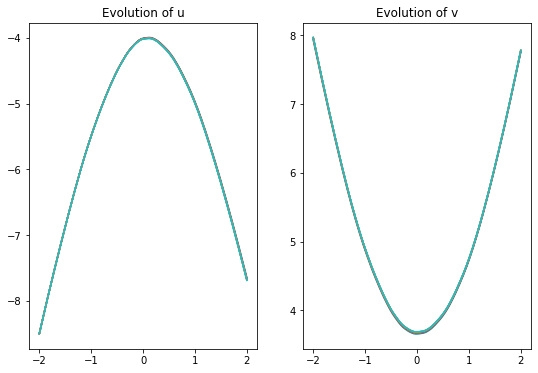

In [511]:
# RUNNING THE MAIN ALGORITHM
w_u_avg_test, w_v_avg_test, objective, evolution_u, evolution_v = KSGD_NNRF()

### Graphs of the potentials

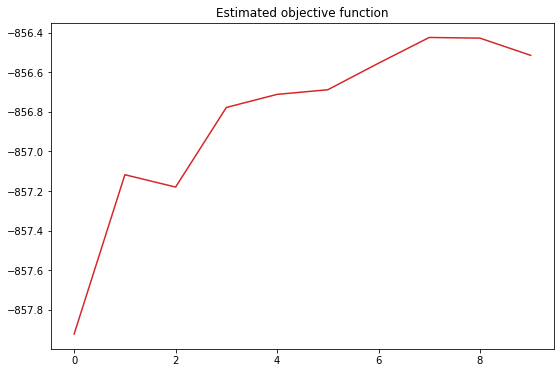

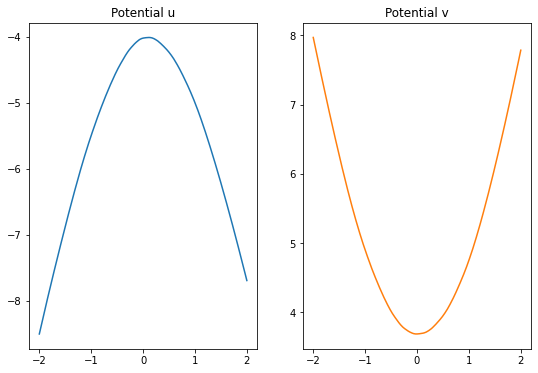

In [512]:
# OBJECTIVE FUNCTION GROWTH AND FINAL POTENTIALS
u = np.dot(w_u_avg_test, np.transpose(global_phi))
v = np.dot(w_v_avg_test, np.transpose(global_phi))
    
# PLOTS
plt.plot(objective, 'tab:red')
plt.title('Estimated objective function')
plt.show()

plt.subplot(1,2,1)
plt.plot(x, u)
plt.title('Potential u')
plt.subplot(1,2,2)
plt.plot(x, v, 'tab:orange')
plt.title('Potential v')
plt.show()

### Optimality conditions

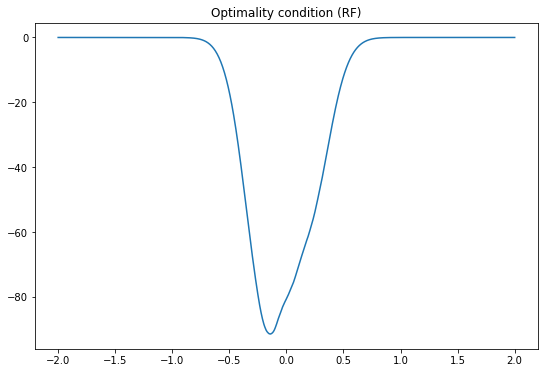

Estimated objective at RF approximation :  -856.481175733641
Norm of coefficients :  26.906769532532124


In [518]:
# OPTIMALITY CONDITIONS
plt.plot(x, optimality_condition(u, v))
plt.title('Optimality condition (RF)')
plt.show()

# OBJECTIVE ACHIEVED
print('Estimated objective at RF approximation : ', estimate_objective(u, v))

# PROJECTION CONSTRAINT
print('Norm of coefficients : ', np.linalg.norm(w_u_avg_test))

### Comparison to exact solution (for the first test only)

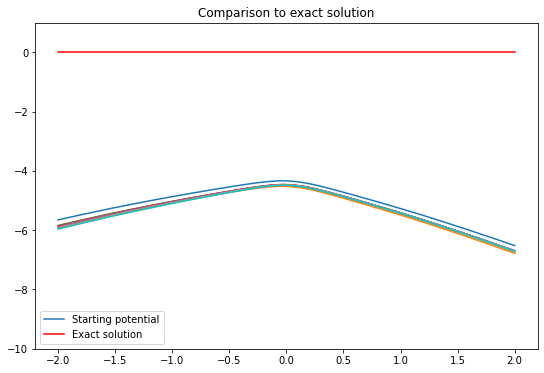

In [345]:
# EVOLUTION
plt.plot(x, evolution_u[0], label='Starting potential')
for i in range(len(evolution_u)-1):
    plt.plot(x, evolution_u[i+1])
    
plt.plot(x, -0.5*epsilon*(0.00089)*x**2, 'r', label='Exact solution')
plt.legend()
plt.ylim([-10,1])
plt.title('Comparison to exact solution')
plt.show()

In [ ]:
# GRAPHICALLY COMPARING FINAL POTENTIALS
plt.subplot(1,2,1)
plt.plot(x, -0.5*epsilon*(0.00089)*x**2)
plt.plot(x, u)
plt.ylim([-2,2])
plt.legend(['u Exact', 'u RF'])
plt.title('Comparing u')
plt.subplot(1,2,2)
plt.plot(x, -0.5*epsilon*(0.00089)*x**2)
plt.plot(x, v)
plt.ylim([-2,2])
plt.legend(['v Exact', 'v RF'])
plt.title('Comparing v')
plt.show()

In [ ]:
# RELATIVE L^2 ERROR COMPARED TO EXACT SOLUTION
error_evolution_u = np.apply_along_axis(lambda x : np.linalg.norm(x + 0.5*epsilon*(0.00089)*x**2),
                                        axis=1,
                                        arr=evolution_u)
plt.subplot(2,2,1)
plt.plot(error_evolution_u)
plt.title('Error relative to exact solution for u \n (min = {:.3f})'.format(np.min(error_evolution_u)))
error_evolution_v = np.apply_along_axis(lambda x : np.linalg.norm(x + 0.5*epsilon*(0.00089)*x**2),
                                        axis=1,
                                        arr=evolution_v)
plt.subplot(2,2,2)
plt.plot(error_evolution_v)
plt.title('Error relative to exact solution for v \n (min = {:.3f})'.format(np.min(error_evolution_v)))
plt.subplot(2,2,3)
plt.loglog(error_evolution_u)
plt.title('log-log error relative to exact solution for u')
plt.subplot(2,2,4)
plt.loglog(error_evolution_v)
plt.title('log-log error relative to exact solution for v')
plt.subplots_adjust(top=1.2, right=1)
plt.show()

## Appendix : random features approximate exact kernels

In [ ]:
# EXACT EXPRESSION FOR ReLU FEATURES
base_point = -1
k1 = np.apply_along_axis(lambda p : k1_exact(base_point, p), 0, x)

# APPROXIMATION
phi_1 = NNRF([base_point])
phi_2 = np.array(list(map(lambda p : NNRF([p]), x)))

# COMPARISON
plt.plot(x, np.dot(phi_2, phi_1))
plt.plot(x, k1)
plt.legend(['Approximation','Exact'])
plt.title('Comparing RF approximation to exact kernel')

## References
Francis Bach. *Breaking the curse of dimensionality with convex neural networks*. The Journal of Machine Learning Research, 18(1):629–681, 2017.